In [2]:
from matplotlib import pyplot as pl
from scipy import signal 
import matplotlib.pyplot as pl
import os
import numpy as np
import csv


%matplotlib inline

data_dir = '/home/mzhan/audiosearch/data/UrbanSound8K/audio' 
metadata_path = '/home/mzhan/audiosearch/data/UrbanSound8K/metadata/UrbanSound8K_by_fold.csv'

In [4]:
errorfiles = []
def data_gen(verbose=False):
    """ 
    Generate spectrogram for each audio file (in log amplitude). 
    Yields numpy array of shape (n,d) where n is number of windows (number of frames in file) and 
    d is STFT resolution (frame dimension).
    """
    SR = 44100   # standard sampling rate
    with open(metadata_path, 'rb') as fmeta:
        meta = csv.reader(fmeta, delimiter=',')
        meta.next()   # skip header
        for line in meta:
            fname, fsID, start, end, salience, fold, classID, className = line
            if verbose:
                print fname, fold
            try: 
                s = audiolab.Sndfile(os.path.join(data_dir, 'fold'+str(fold), fname))
                w = s.read_frames(s.nframes)
                resampled = signal.resample(w, 1.*s.nframes/s.samplerate*SR)   # resample wave to standard sampling rate
                frameSize = SR*0.02   # frame duration = 20ms
                if len(w.shape)>1:
                    w = w[:,0]    # take the first channel when multiple are present   
                S = spectrogram.stft(resampled, frameSize)
                yield np.log(np.abs(S))
            except:
                errorfiles.append((fold, fname))   # ignore files that can't be opened by wave package
#    print len(errorfiles)
#    print len(set(map(lambda x: str(x[2]), errorfiles)))
g = data_gen()


In [275]:
g = snd_gen()
samplerates = [s.samplerate for s in g]
print "Number of different sample rates", len(set(samplerates))

Number of different sample rates 11


In [239]:
print set(samplerates)
[sum(np.array(samplerates)==sr) for sr in set(samplerates)]

set([48000, 96000, 22050, 44100, 8000, 32000, 11024, 11025, 24000, 192000, 16000])


[2502, 610, 44, 5370, 12, 4, 7, 39, 82, 17, 45]

## Vector quantization on audio frames (kmeans)

In [5]:
NC = 512
quantizer = vq.VectorQuantizer(clusterer=hartigan.HartiganOnline(n_clusters=NC))
max_iter = 5
centroids = np.zeros((max_iter, 8, NC, 442))

In [6]:
i=0
print "iteration", i+1
#g = data_gen()   # reset generator
fcount=0
for d in g:
    #print d.shape
    quantizer.partial_fit(d)    
    fcount+=1
    if not fcount%50:
        print fcount, 'files processed'
    if fcount>0 and not fcount%1000:
        # save centroids
        centroids[i, fcount/1000-1] = quantizer.components_
        

iteration 1
50 files processed
100 files processed
150 files processed
200 files processed
250 files processed
300 files processed
350 files processed
400 files processed
450 files processed
500 files processed
550 files processed
600 files processed
650 files processed
700 files processed
750 files processed
800 files processed
850 files processed
900 files processed
950 files processed
1000 files processed
1050 files processed
1100 files processed
1150 files processed
1200 files processed
1250 files processed
1300 files processed
1350 files processed
1400 files processed
1450 files processed
1500 files processed
1550 files processed
1600 files processed
1650 files processed
1700 files processed
1750 files processed
1800 files processed
1850 files processed
1900 files processed
1950 files processed
2000 files processed
2050 files processed
2100 files processed
2150 files processed
2200 files processed
2250 files processed
2300 files processed
2350 files processed
2400 files processed


In [106]:
np.var(centroids[1,7])

1.3200181598066004e+19

In [66]:
d = random_audio_file()
w = wv.read(d)
quantizer.transform(w)

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

(512, 513)


<matplotlib.colorbar.Colorbar instance at 0x7f37fe21a5f0>

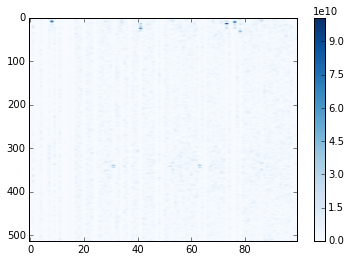

In [103]:
print quantizer.components_.shape
pl.imshow(np.abs(centroids[1,7,:100,:]).T, aspect='auto', cmap=pl.get_cmap('Blues'))
pl.colorbar()

In [33]:
g.next()

StopIteration: 

In [8]:
centroids = quantizer.centroids()

AttributeError: 'HartiganOnline' object has no attribute 'cluster_centers_'

In [15]:
h = hartigan.HartiganOnline(n_clusters=128)
g = data_gen()
for (d,f) in g:
    print d.shape
    h.partial_fit(d)


In [ ]:
g = data_gen()
g.next()

# Data Overview & Exploration

In [356]:
len(errorfiles)

0

In [36]:
import random
def random_audio_file():
    fold = random.choice(os.listdir(data_dir))
    fname = random.choice(os.listdir(os.path.join(data_dir, fold)))
    return os.path.join(data_dir, fold, fname)
    

Exception RuntimeError: 'generator ignored GeneratorExit' in <generator object data_gen at 0x7f74aa2f5780> ignored
/usr/lib/python2.7/dist-packages/scipy/io/wavfile.py:42: WavFileWarning: Unknown wave file format
  warnings.warn("Unknown wave file format", WavFileWarning)


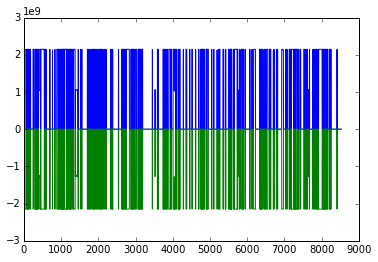

In [14]:
# Check data audio volumn range
maxs = []
mins = []
g = data_gen()

for w,sr in g:
    maxs.append(np.max(w))
    mins.append(np.min(w))
pl.plot(maxs)
pl.plot(mins)

In [16]:
# check audio files that can't be opened
len(errorfiles)
for fold, fname in errorfiles:
    print fold, fname
#    sr,w = wv.read(os.path.join(data_dir, 'fold'+str(fold), fname))
    

1 101415-3-0-2.wav
1 122690-6-0-0.wav
1 162540-1-2-0.wav
1 164312-3-1-0.wav
1 164312-3-3-0.wav
1 175845-1-0-0.wav
1 184355-1-0-0.wav
1 197073-3-0-0.wav
1 197073-3-3-0.wav
1 197318-6-3-0.wav
1 197318-6-4-0.wav
1 197318-6-5-0.wav
1 54858-3-2-0.wav
1 71087-4-0-0.wav
1 88466-7-0-0.wav
1 94868-1-2-0.wav
2 118723-4-0-0.wav
2 155129-1-0-0.wav
2 155129-1-1-0.wav
2 155234-1-0-0.wav
2 158607-3-1-0.wav
2 162541-1-0-0.wav
2 162541-1-2-0.wav
2 165775-7-0-0.wav
2 197320-6-12-0.wav
2 197320-6-5-0.wav
2 23131-3-0-0.wav
2 23131-3-2-0.wav
2 23131-3-4-0.wav
2 71080-4-0-0.wav
2 71080-4-1-0.wav
3 118070-1-0-0.wav
3 128030-3-0-0.wav
3 128030-3-2-0.wav
3 144068-5-3-0.wav
3 162431-6-1-0.wav
3 162431-6-2-0.wav
3 162431-6-3-0.wav
3 162436-6-0-0.wav
3 170015-3-0-0.wav
3 179863-1-0-0.wav
3 188824-7-10-0.wav
3 188824-7-11-0.wav
3 188824-7-4-0.wav
3 188824-7-8-0.wav
4 109711-3-1-0.wav
4 121888-3-0-0.wav
4 156362-4-1-0.wav
4 158977-6-0-0.wav
4 162435-6-0-0.wav
4 162435-6-1-0.wav
4 162435-6-3-0.wav
4 187356-1-1-0.wav

In [21]:
# try another package
errors2 = []

for fold, fname in errorfiles[1:]:
    try: 
        sr, sw, w = wavio.readwav(os.path.join(data_dir, 'fold'+str(fold), fname))
        print fold, fname
    except:
        errors2.append((fold, fname))
    

In [19]:
len(errors2)

199

In [13]:
allfnames = []     # names of all audio files
for fold in [f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir,f))]:
    fold_dir = os.path.join(data_dir, fold)
    print fold_dir
    fnames = os.listdir(fold_dir)   
    allfnames += fnames
len(allfnames)
len(set(allfnames))

/home/mzhan/audiosearch/data/UrbanSound8K/audio/fold7
/home/mzhan/audiosearch/data/UrbanSound8K/audio/fold5
/home/mzhan/audiosearch/data/UrbanSound8K/audio/fold4
/home/mzhan/audiosearch/data/UrbanSound8K/audio/fold9
/home/mzhan/audiosearch/data/UrbanSound8K/audio/fold1
/home/mzhan/audiosearch/data/UrbanSound8K/audio/fold3
/home/mzhan/audiosearch/data/UrbanSound8K/audio/fold2
/home/mzhan/audiosearch/data/UrbanSound8K/audio/fold10
/home/mzhan/audiosearch/data/UrbanSound8K/audio/fold8
/home/mzhan/audiosearch/data/UrbanSound8K/audio/fold6
